<a href="https://colab.research.google.com/github/mpiatek26/Directing_Customers_to_Subscription_Through_App_Behavior_Analysis_EDA/blob/main/Directing_Customers_to_Subscription_Through_App_Behavior_Analysis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
#### Importing Libraries ####

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import time

In [35]:
dataset = pd.read_csv('new_appdata10.csv')

In [36]:
#### Data Pre-Processing ####

# Splitting Independent and Response Variables
response = dataset["enrolled"]
dataset = dataset.drop(columns="enrolled")

In [37]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, response,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [13]:
## Balancing the Training Set
#import random
#y_train.value_counts()

#pos_index = y_train[y_train.values == 1].index
#neg_index = y_train[y_train.values == 0].index

#if len(pos_index) > len(neg_index):
    #higher = pos_index
    #lower = neg_index
#else:
    #higher = neg_index
    #lower = pos_index

#random.seed(0)
#higher = np.random.choice(higher, size=len(lower))
#lower = np.asarray(lower)
#new_indexes = np.concatenate((lower, higher))

#X_train = X_train.loc[new_indexes,]
#y_train = y_train[new_indexes]

In [38]:
# Removing Identifiers
train_identity = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_identity = X_test['user']
X_test = X_test.drop(columns = ['user'])

In [39]:
non_numeric_columns = X_train.select_dtypes(exclude=[np.number]).columns
print(non_numeric_columns)

Index(['first_open', 'hour', 'screen_list', 'enrolled_date'], dtype='object')


In [40]:
X_train = X_train.drop(columns=['first_open', 'hour', 'screen_list', 'enrolled_date'])
X_test = X_test.drop(columns=['first_open', 'hour', 'screen_list', 'enrolled_date'])


In [41]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

In [42]:
#### Model Building ####


# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, penalty='l1', solver='liblinear')

classifier.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

In [52]:
# Predicting Test Set
y_pred = classifier.predict(X_test)

In [53]:
# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)

In [54]:
accuracy_score(y_test, y_pred)

0.6599

In [55]:
precision_score(y_test, y_pred) # tp / (tp + fp)

0.6714494163424124

In [56]:
recall_score(y_test, y_pred) # tp / (tp + fn)

0.8876386433049349

In [57]:
f1_score(y_test, y_pred)

0.7645552094150224

Test Data Accuracy: 0.6599


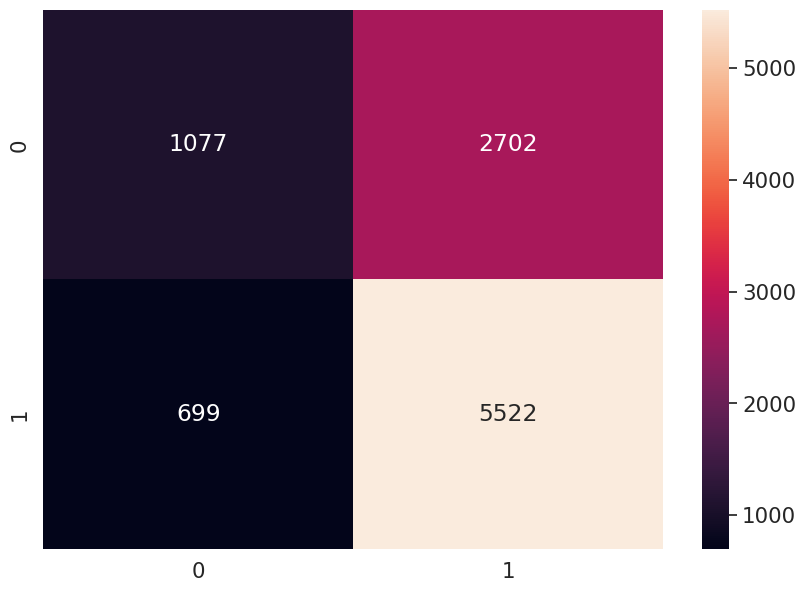

In [59]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [60]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

SVM Accuracy: 0.659 (+/- 0.010)


In [61]:
# Analyzing Coefficients
pd.concat([pd.DataFrame(dataset.drop(columns = 'user').columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,first_open,0.033949
1,dayofweek,-0.229248
2,hour,0.508871
3,age,0.261269
4,screen_list,-0.175004
5,numscreens,-0.004142
6,minigame,NaN
7,used_premium_feature,NaN
8,enrolled_date,NaN
9,liked,NaN


In [62]:
#### Model Tuning ####

## Grid Search (Round 1)
from sklearn.model_selection import GridSearchCV

In [63]:
# Select Regularization Method
penalty = ['l1', 'l2']

In [64]:
# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [65]:
# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters

Took 6.86 seconds


(0.65955, {'C': 0.01, 'penalty': 'l1'})

In [66]:
## Grid Search (Round 2)

# Select Regularization Method
penalty = ['l1', 'l2']

In [67]:
# Create regularization hyperparameter space
C = [0.1, 0.5, 0.9, 1, 2, 5]

In [68]:
# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters
grid_search.best_score_

Took 6.90 seconds


0.6590500000000001

In [71]:
#### End of Model ####


# Formatting Final Results
final_results = pd.concat([y_test, test_identity], axis = 1).dropna()

In [72]:
final_results['predicted_reach'] = y_pred

In [73]:
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)

In [74]:
print(final_results)

        user  enrolled  predicted_reach
0     239786         1                1
1     279644         1                1
2      98290         0                0
3     170150         1                1
4     237568         1                1
...      ...       ...              ...
9995  143036         1                1
9996   91158         1                1
9997  248318         0                1
9998  142418         1                1
9999  279355         1                1

[10000 rows x 3 columns]
